In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from matplotlib.pyplot import figure
import cv2
import itertools
from keras.utils import np_utils
from sklearn import preprocessing

from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix

In [ ]:
SEED = 8743
batchSize = 50
epochs = 50

In [ ]:
images = np.load('/content/sample_data/images.npy')

In [ ]:
labels = pd.read_csv('/content/sample_data/Labels.csv')

In [ ]:
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

In [ ]:
images.shape

(4750, 128, 128, 3)

### Visualize some images

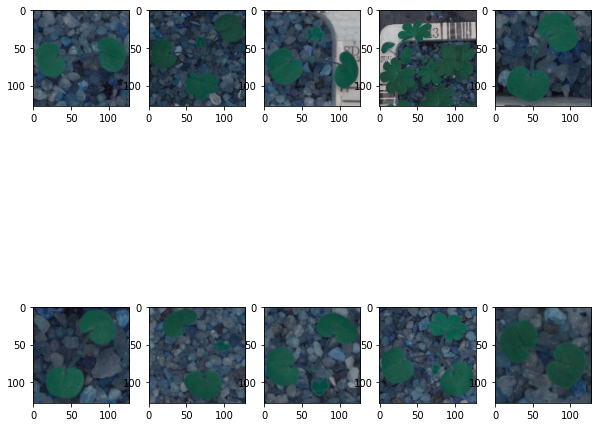

In [ ]:
plt.figure(figsize=[10,10])
#visualize few images
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(images[i])

### Blur images using GaussianBlur from CV2

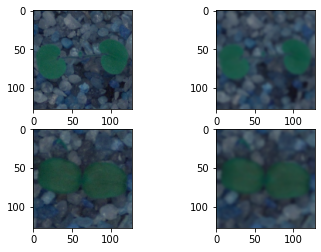

In [ ]:
blurredImages = []
for img in images:
  gaussianImage = cv2.GaussianBlur(img,(7,7),0)
  blurredImages.append(gaussianImage)

plt.subplot(2,2,1);plt.imshow(images[0])
plt.subplot(2,2,2);plt.imshow(blurredImages[0])
plt.subplot(2,2,3);plt.imshow(images[2499])
plt.subplot(2,2,4);plt.imshow(blurredImages[2499])

blurredImages = np.asarray(blurredImages)

In [ ]:
blurredImages.shape

(4750, 128, 128, 3)

### lets split the data into train and test set

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(blurredImages, labels,test_size=0.3, random_state=SEED,stratify = labels)

In [ ]:
print('Shape of training set X: ',x_train.shape)
print('Shape of training set Y: ',y_train.shape)
print('Shape of test set X: ',x_test.shape)
print('Shape of test set Y: ',y_test.shape)

Shape of training set X:  (3325, 128, 128, 3)
Shape of training set Y:  (3325, 1)
Shape of test set X:  (1425, 128, 128, 3)
Shape of test set Y:  (1425, 1)


In [ ]:
x_train[49, :, :, :].shape

(128, 128, 3)

### Normalize Input

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.
x_test = x_test / 255.

### Encode labels

In [ ]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

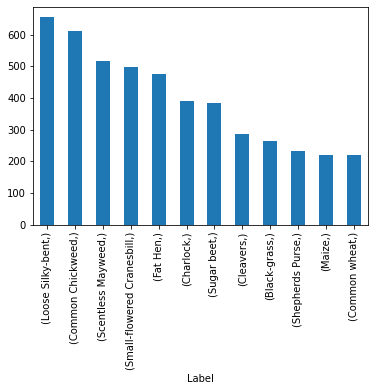

In [ ]:
labels.value_counts().plot(kind='bar')
plt.show()

### Image Generator

In [ ]:
imageGenerator = ImageDataGenerator(
    rotation_range = 180,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True
)

imageGenerator.fit(x_train)


### Create Model

In [ ]:
def createModel():
  model = Sequential()

  model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(128, 128, 3), activation='relu'))
  model.add(BatchNormalization(axis=3))
  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization(axis=3))
  model.add(Dropout(0.1))

  model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
  model.add(BatchNormalization(axis=3))
  model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization(axis=3))
  model.add(Dropout(0.1))

  model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
  model.add(BatchNormalization(axis=3))
  model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization(axis=3))
  model.add(Dropout(0.1))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(y_train.shape[1], activation='softmax'))

  model.summary()

  # compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = createModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       2

### Callbacks

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

model_checkpoint =  ModelCheckpoint('Model_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           save_freq = 'epoch')

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

### Split Validation set

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.2, random_state=SEED,stratify = y_train)

### Fit model

In [ ]:
hist = model.fit(x_train,
                y_train,
                batch_size=batchSize,
                epochs=epochs,
                validation_data=(x_val, y_val),
                callbacks=[early_stopping,model_checkpoint])

Epoch 1/50
54/54 [==============================] - 12s 227ms/step - loss: 0.1051 - accuracy: 0.9639 - val_loss: 0.7694 - val_accuracy: 0.7699

Epoch 00001: val_loss did not improve from 0.55447
Epoch 2/50
54/54 [==============================] - 10s 188ms/step - loss: 0.0964 - accuracy: 0.9647 - val_loss: 0.2478 - val_accuracy: 0.9338

Epoch 00002: val_loss improved from 0.55447 to 0.24777, saving model to Model_cnn_checkpoint_02_loss0.2478.h5
Epoch 3/50
54/54 [==============================] - 10s 185ms/step - loss: 0.0998 - accuracy: 0.9654 - val_loss: 0.7660 - val_accuracy: 0.7940

Epoch 00003: val_loss did not improve from 0.24777
Epoch 4/50
54/54 [==============================] - 10s 183ms/step - loss: 0.1567 - accuracy: 0.9466 - val_loss: 1.1761 - val_accuracy: 0.7038

Epoch 00004: val_loss did not improve from 0.24777
Epoch 5/50
54/54 [==============================] - 10s 182ms/step - loss: 0.1308 - accuracy: 0.9523 - val_loss: 0.6817 - val_accuracy: 0.8105

Epoch 00005: val_

### Visualizing Loss

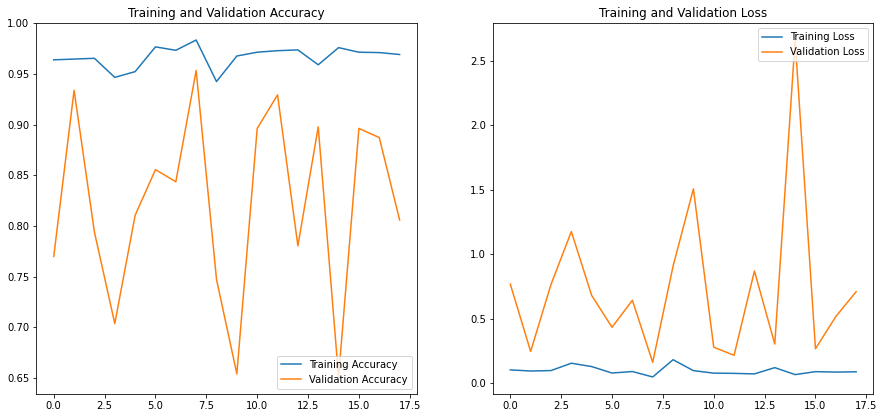

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = hist.epoch

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see that model on epoch 20 has a better validation accuracy and lower loss. 

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred,axis=1)
print(y_pred_classes)

y_pred = enc.fit_transform(y_pred_classes)
print(y_pred)

#conf_matrix = confusion_matrix(y_test, y_pred) 

[0 6 3 ... 0 0 4]
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Test Loss and Accuracy

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

45/45 [==============================] - 1s 32ms/step - loss: 1.0680 - accuracy: 0.7586
Test loss: 1.0680394172668457
Test accuracy: 0.7585964798927307


Test accuracy is about 76%. While we can use learning rate as our callback, I did not use since it was taking way too long and was getting crashed.

In [ ]:
'''
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
'''

In [ ]:
#plot_confusion_matrix(conf_matrix, classes = sorted(set(labels.Label))) 